# Wasserstein-based clustering

References:
- https://medium.com/@amina.kaltayeva/market-regime-detection-why-understanding-ml-algorithms-matters-4eb7e8cac755

In [25]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wkmeans import WKMeans

In [26]:
# Data
df = pd.read_parquet("btc_binance_1d.parquet")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [27]:
# The number of clusters
k = 3

# Features computation
df_features = pd.DataFrame(index=df.index)

# Log returns
df_features['Returns'] = np.log(df['Close'] / df['Close'].shift())

# Volatility and MA
for ma in [5, 10, 15, 30, 60, 180]:
    df_features['MA'+str(ma)] = df_features['Returns'].rolling(window=ma).mean()
for ma in [15, 60, 180]:
    df_features['Volatility'+str(ma)] = df_features['Returns'].rolling(window=ma).std()

df_features.dropna(inplace=True)

In [13]:
df_features.head()

,Returns,MA5,MA10,MA15,MA30,MA60,MA180,Volatility15,Volatility60,Volatility180
Date,,,,,,,,,,
2018-02-13,-0.041639,0.018535,-0.007445,-0.018381,-0.015203,-0.011995,0.003831,0.083067,0.075238,0.062285
2018-02-14,0.101264,0.016908,0.014373,-0.005336,-0.011988,-0.011730,0.004628,0.085601,0.075614,0.062610
2018-02-15,0.056580,0.031708,0.036529,-0.001873,-0.002872,-0.010574,0.004899,0.087071,0.076127,0.062729
2018-02-16,0.015862,0.046212,0.028347,0.006439,-0.002614,-0.010306,0.005060,0.081931,0.076192,0.062720
2018-02-17,0.083028,0.043019,0.037347,0.014565,0.000235,-0.007482,0.005618,0.083153,0.076463,0.062965


In [28]:
# Define dataset
dataset = df_features.values

# Run k-means
kmeans=KMeans(n_clusters=k)
kmeans.fit(dataset)

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['wk'] = wkmeans.predict(dataset)

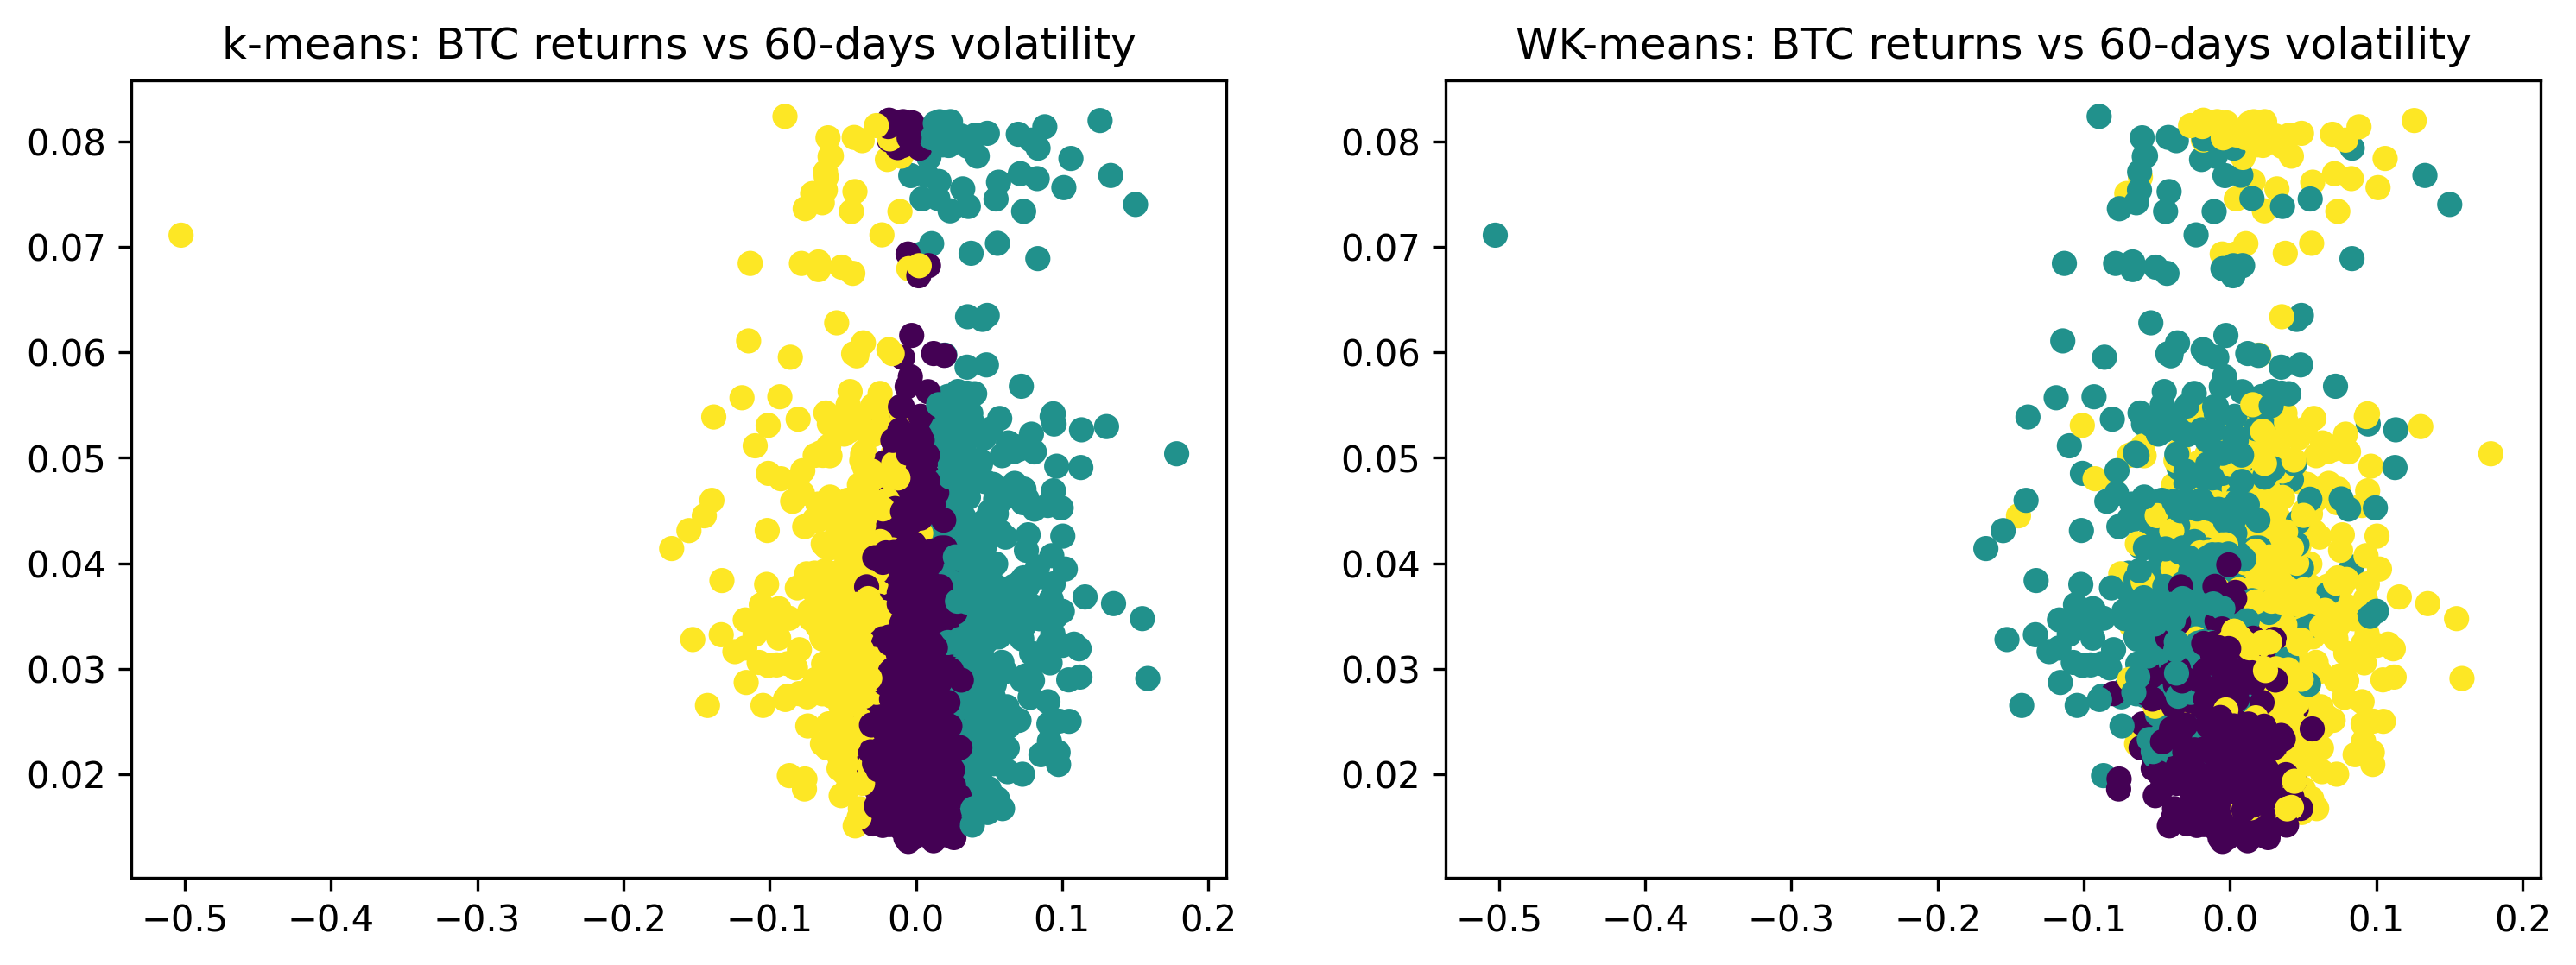

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(12, 4))

axes[0].scatter(df_features['Returns'].values, 
            df_features['Volatility60'].values,
            c=df_features['cluster'].values)

axes[0].set_title('k-means: BTC returns vs 60-days volatility')

axes[1].scatter(df_features['Returns'].values, 
            df_features['Volatility60'].values,
            c=df_features['wk'].values)

axes[1].set_title('WK-means: BTC returns vs 60-days volatility')
plt.show()

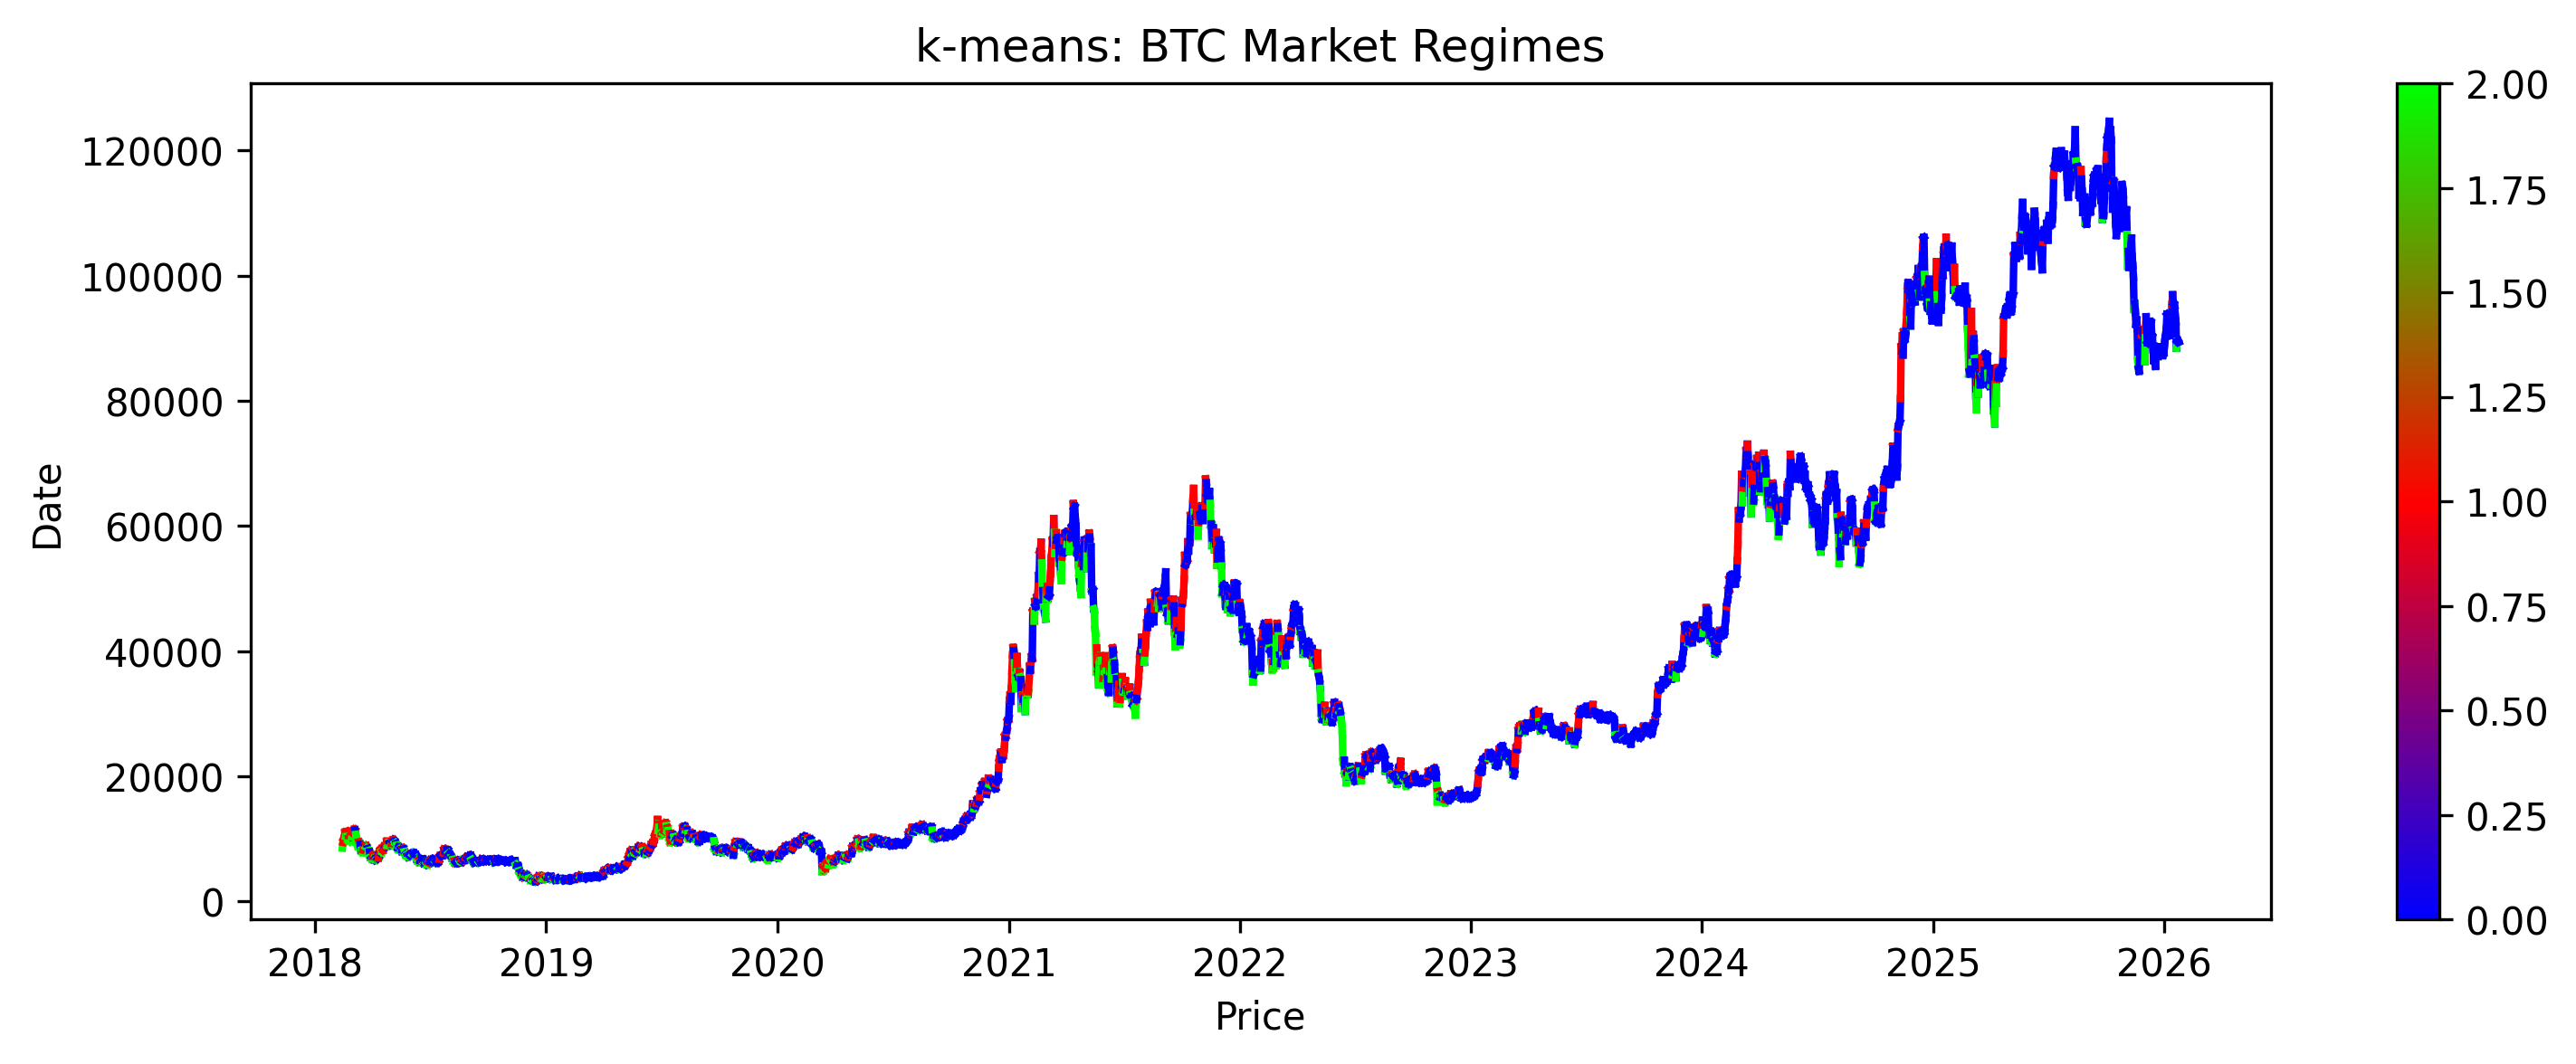

In [ ]:
df = pd.concat([df, df_features['cluster']], axis=1)
df.dropna(inplace=True)
n = len(df)
# Normalize color values for better visualization
norm = plt.Normalize(df['cluster'].min(), df['cluster'].max())
cmap = plt.cm.brg  # Choose a colormap (e.g., 'viridis', 'coolwarm', 'jet')

# Plot line with dynamic coloring
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
for i in range(n - 1):
    ax.plot(df['Close'].iloc[i:i+2], color=cmap(norm(df['cluster'].iloc[i])), linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Labels and title
ax.set_xlabel("Price")
ax.set_ylabel("Date")
ax.set_title("k-means: BTC Market Regimes")

plt.show()

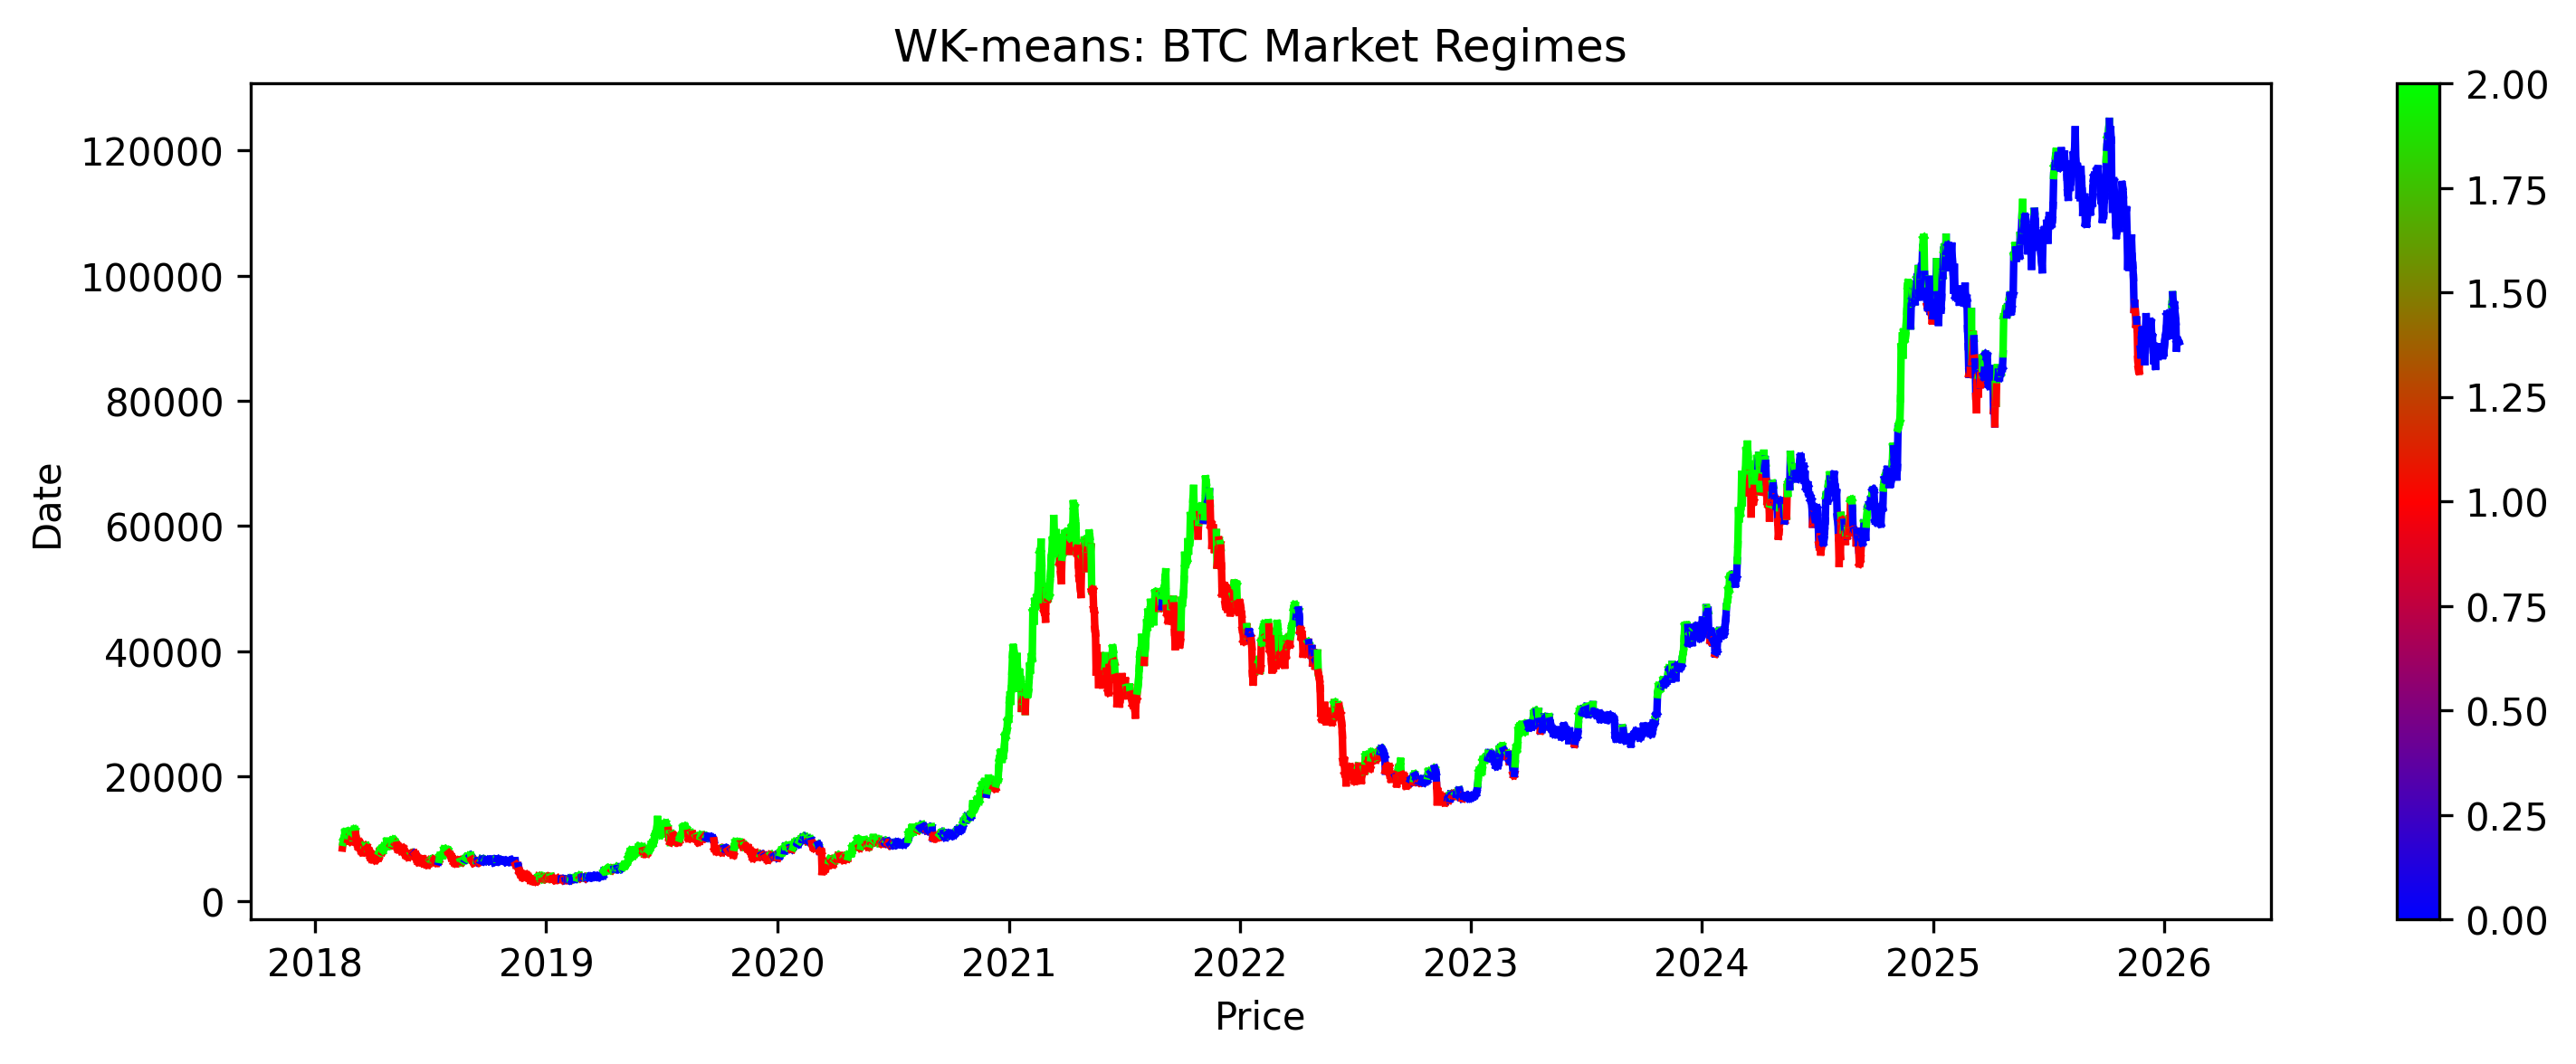

In [34]:
df = pd.concat([df, df_features['wk']], axis=1)

n = len(df)
# Normalize color values for better visualization
norm = plt.Normalize(df['wk'].min(), df['wk'].max())
cmap = plt.cm.brg # Choose a colormap (e.g., 'viridis', 'coolwarm', 'jet')

# Plot line with dynamic coloring
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
for i in range(0, n - 1):
    ax.plot(df['Close'].iloc[i:i+2], color=cmap(norm(df['wk'].iloc[i])), linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Labels and title
ax.set_xlabel("Price")
ax.set_ylabel("Date")
ax.set_title("WK-means: BTC Market Regimes")

plt.show()